In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import pickle 
from copy import deepcopy
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.metrics import confusion_matrix
import plotly.express as px

def pkl_save(path, obj):
  with open(path, 'wb') as file:
    pickle.dump(obj, file)

def pkl_load(path):
  with open(path, 'rb') as file:
    return pickle.load(file)

In [2]:
def top135(logits, y):
    top = {i: logits.topk(i, 1).indices for i in [1,3,5]}
    correct = {
        i: pd.Series([actual in guesses for actual, guesses in zip(y, top[i])])
        for i in [1,3,5]
    }
    return [correct[i].mean() for i in [1,3,5]]

In [3]:
data = pd.read_csv("data.csv")

In [4]:
# Most common countries make up a significant fraction of our dataset
data[data.set=='train'].groupby('country_name').id.count().sort_values(ascending=False)[:5]

country_name
United States         15236
France                 4892
Russian Federation     4311
Japan                  4070
United Kingdom         3868
Name: id, dtype: int64

In [5]:
country_counts = data[data.set=='train'].groupby('country_idx').id.count()
geocell_counts = data[data.set=='train'].groupby('geocell_idx').id.count()

num_test = sum(data.set=='test')

naive_country_logits = torch.zeros(num_test,len(country_counts))
naive_country_logits += torch.tensor(country_counts) / 1000

naive_geocell_logits = torch.zeros(num_test,len(geocell_counts))
naive_geocell_logits += torch.tensor(geocell_counts) / 100

In [6]:
data = pd.read_csv("data.csv")
test_idx = data.index[data.set=='test']
data_test = data.iloc[test_idx]

In [7]:
# World
logits = pkl_load("logits_country")[test_idx]
y = data_test.country_idx
top135(logits, y)

[0.7525497063974451, 0.8993509838261049, 0.9373647882971052]

In [8]:
top135(naive_country_logits, y)

[0.19336561244462758, 0.31224889255176674, 0.4177397754198001]

In [9]:
# Geocell
logits = pkl_load("logits_geocell")[test_idx]
y = data_test.geocell_idx
top135(logits, y)

[0.3484083650973524, 0.5951375296178016, 0.7110332749562172]

In [10]:
top135(naive_geocell_logits, y)

[0.006387143298650458, 0.01854331925414649, 0.029566292366333572]

In [11]:
# US - single images
logits = pkl_load("logits_us_test")
y = pkl_load("us_test_y")
top135(logits, y)

[0.6410166678331817, 0.8377410936578245, 0.903062601861758]

In [12]:
# US - groups of 4
ids = pkl_load('us_test_id')
probs = torch.softmax(logits, 1).tolist()
probsdf = pd.DataFrame(probs)
probsdf['y'] = y

probs_and_y = probsdf.groupby(ids).mean()
mean_y = probs_and_y['y']
del probs_and_y['y']
mean_probs = torch.tensor(probs_and_y.to_numpy())
top135(mean_probs, mean_y)

[0.924061262846403, 0.9799256208261686, 0.9928420042388131]

In [13]:
# ANALYZE PRECISION + RECALL FOR COUNTRIES #

In [14]:
data_pr = deepcopy(data)
data_pr['country_pred'] = pkl_load('logits_country').argmax(1)
data_pr['geocell_pred'] = pkl_load('logits_geocell').argmax(1)
data_pr['country_correct'] = data_pr.country_idx == data_pr.country_pred
data_pr['geocell_correct'] = data_pr.geocell_idx == data_pr.geocell_pred
data_pr = data_pr[data_pr.set.isin(['valid','test'])]

In [15]:
# Remove small countries
THRESH = 100
counts = data_pr.country_idx.value_counts()
countries_large = counts[counts>=THRESH].index
countries_large

Int64Index([83, 28, 44, 70, 29, 10, 13, 56, 25,  5, 86, 65, 42, 26, 60, 71,  2,
            68, 77, 61, 59, 67, 79, 40, 15, 17, 38, 62, 37,  8, 80, 32, 72, 57,
            12, 18],
           dtype='int64')

In [16]:
recall = data_pr.groupby('country_idx')['country_correct'].mean()[countries_large]
recall.name = 'recall'

precision = data_pr.groupby('country_pred')['country_correct'].mean()[countries_large]
precision.name = 'precision'

pr = pd.concat([precision, recall], 1)
pr.head()

precision    recall
83   0.835167  0.925749
28   0.713058  0.677551
44   0.933870  0.957837
70   0.765501  0.885110
29   0.729828  0.841170

In [17]:
rename = {
    'Taiwan, Province of China': 'Taiwan',
    'Russian Federation': 'Russia',
    'Macedonia, the Former Yugoslav Republic of': 'Macedonia',
    'Bolivia, Plurinational State of': 'Bolivia',
    'Korea, Republic of': 'Korea',
} 
data_pr.country_name = data_pr.country_name.map(lambda c: rename.get(c, c))

In [18]:
idx_to_country = dict(list(zip(data_pr.country_idx, data_pr.country_name)))
country_to_idx = {b:a for a,b in idx_to_country.items()}

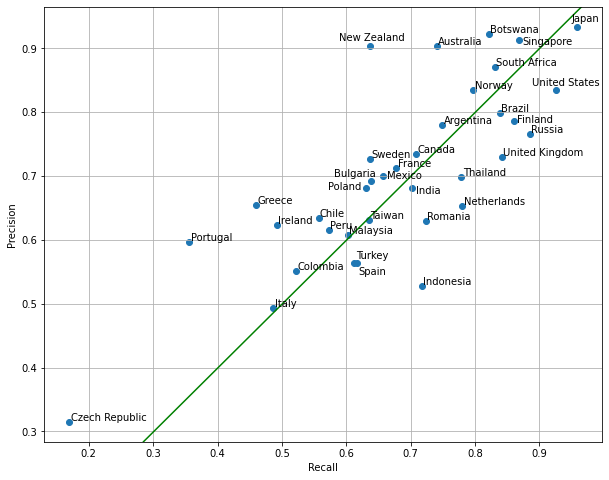

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pr.recall, pr.precision)
for c, p, r in zip(pr.index, pr.precision, pr.recall):
    txt = idx_to_country[c]
    txt = rename.get(txt, txt)
    x, y = r, p
    shifts_x = {
        'Finland': 0.002,
        'Singapore': 0.002,
        'New Zealand': -0.05,
        'Poland': -0.06,
        'Bulgaria': -0.06,
        'India': 0.005,
        'Mexico': 0.005,
        'United States': -0.04,
        'Japan': -0.01,
    }
    shifts_y = {
        'Mexico': -0.005,
        'Finland': -0.005,
        'Singapore': -0.01,
        'Spain': -0.02,
        'Turkey': 0.005,
        'New Zealand': 0.005,
        'Bulgaria': 0.005,
        'Poland': -0.005,
        'India': -0.01,
        'United States': 0.005,
        'Japan': 0.005,
    }
    x += shifts_x.get(txt, 0) + 0.002
    y += shifts_y.get(txt, 0) + 0.002
    ax.annotate(txt, (x, y))

line = matplotlib.lines.Line2D([0.178,.963],[0,1],color='green')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [20]:
y_true, y_pred = data_pr.country_idx, data_pr.country_pred
country_names = pd.Series(data_pr.country_name.unique())
country_idx_ordered = list(map(lambda c: country_to_idx.get(c,0), country_names))

In [21]:
def analyze_acc(countries, recall: bool):
    # recall=False => precision
    ytrue, ypred = (y_true, y_pred) if recall else (y_pred, y_true)

    cm = confusion_matrix(y_true=ytrue, y_pred=ypred, labels=country_idx_ordered)
    df_cm = pd.DataFrame(cm, index=country_names, columns=country_names)
    df_cm = df_cm.divide(df_cm.sum(1), 0)
    df_cm = df_cm.loc[countries]

    order = countries + list(set(country_names) - set(countries))
    # Improve the ordering
    country_to_row = df_cm.idxmax(0).sort_values()
    starts = [countries] + [country_to_row[country_to_row==c].index.tolist() for c in countries]
    for start in reversed(starts):
        order = start + [s for s in order if s not in start]
    df_cm = df_cm[order]

    # Remove cols that don't have anything
    df_cm = df_cm.loc[:,df_cm.max(0) > 0.02]

    width, height = (10.5, 2.5) if recall else (12.5, 2.0)
    plt.figure(figsize=(width, height))
    sns.heatmap(df_cm, annot=False, cbar=False, cmap=matplotlib.cm.bone_r)
    plt.show()
    plt.pause(0.001)

In [78]:
sns.set(font_scale=1.9)

Recall


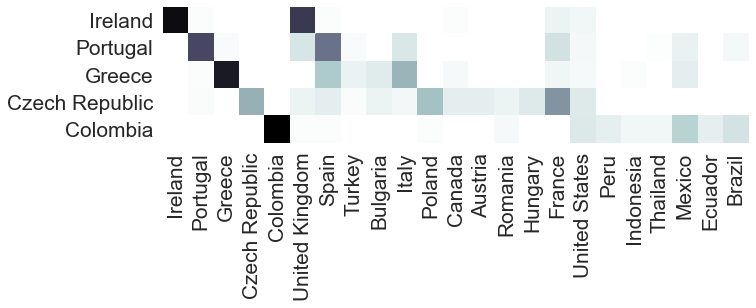

Precision


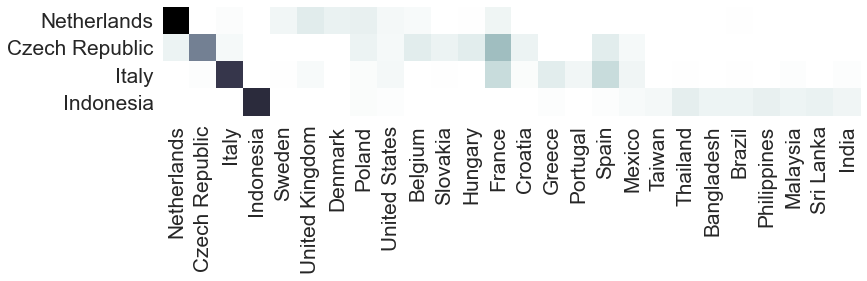

In [79]:
print("Recall")
analyze_acc([
    "Ireland", "Portugal", "Greece", "Czech Republic", "Colombia"
], recall=True)
print("Precision")
analyze_acc([
    "Netherlands", "Czech Republic", "Italy", "Indonesia"
], recall=False)

In [22]:
VOCAB_COUNTRY = ['United Arab Emirates','Albania', 'Argentina','American Samoa','Austria', 'Australia','Bangladesh','Belgium', 'Bulgaria','Bolivia, Plurinational State of','Brazil', 'Bhutan','Botswana', 'Canada','Switzerland','Chile', 'China','Colombia','Czech Republic','Germany','Denmark','Dominican Republic','Ecuador','Estonia','Egypt','Spain','Finland','Faroe Islands','France','United Kingdom','Ghana','Greenland','Greece', 'Guatemala', 'Hong Kong','Croatia','Hungary','Indonesia', 'Ireland','Israel','India','Iceland','Italy','Jordan','Japan','Kenya','Kyrgyzstan','Cambodia','Korea, Republic of','Sri Lanka', 'Lesotho','Lithuania','Latvia','Madagascar','Macedonia, the Former Yugoslav Republic of','Mongolia','Mexico','Malaysia','Nigeria','Netherlands','Norway','New Zealand','Peru','Philippines','Pakistan','Poland','Puerto Rico','Portugal','Romania','Serbia','Russian Federation','Sweden','Singapore','Slovenia','Slovakia','Senegal','Swaziland','Thailand','Tunisia','Turkey','Taiwan, Province of China','Ukraine','Uganda','United States','Uruguay','Viet Nam', 'South Africa']
VOCAB_COUNTRY = [rename.get(c,c) for c in VOCAB_COUNTRY]

In [31]:
matplotlib.rcParams.update({'font.size': 15})

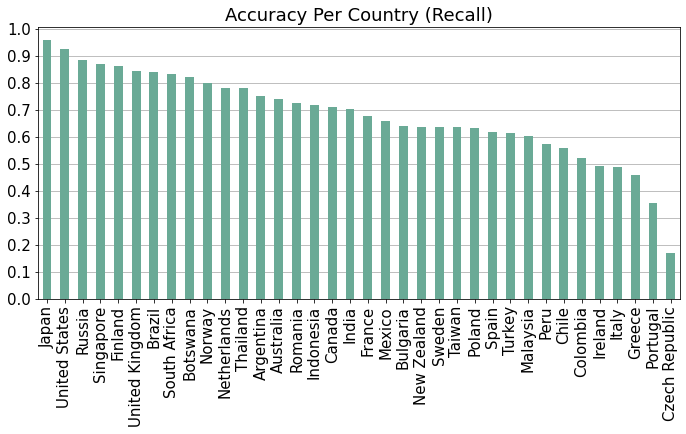

In [32]:
recall_plot = recall.copy()
recall_plot.index = recall_plot.index.map(dict(enumerate(VOCAB_COUNTRY)))

fig, ax = plt.subplots(figsize=(11.5,5))
recall_plot.sort_values(ascending=False).plot.bar(ax=ax, color="#6aaa96", zorder=3)
plt.xlabel("")
plt.yticks(np.arange(0,1.01,0.1))
ax.grid(axis='y', zorder=0)
plt.title("Accuracy Per Country (Recall)")
plt.show()

In [33]:
# Repeat same for states

In [34]:
y_hat = pkl_load("logits_us_test").argmax(1).numpy()
y = np.array(pkl_load("us_test_y"))

In [35]:
VOCAB = ['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut','Delaware','Florida','Georgia','Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine','Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska','Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota','Ohio','Oklahoma','Oregon','Pennsylvania','Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont','Virginia','Washington','West Virginia','Wisconsin','Wyoming']

In [36]:
pr_data = pd.DataFrame({'y': y, 'y_hat': y_hat, 'correct': y==y_hat})
pr_data['y_state'] = [VOCAB[i] for i in pr_data.y]
pr_data['y_hat_state'] = [VOCAB[i] for i in pr_data.y_hat]
pr_data.tail()

y  y_hat  correct  y_state y_hat_state
100008  49     43    False  Wyoming        Utah
100009  49      5    False  Wyoming    Colorado
100010  49     43    False  Wyoming        Utah
100011  49     30    False  Wyoming  New Mexico
100012  49      5    False  Wyoming    Colorado

In [37]:
recall = pr_data.groupby('y_state').correct.mean()
precision = pr_data.groupby('y_hat_state').correct.mean()

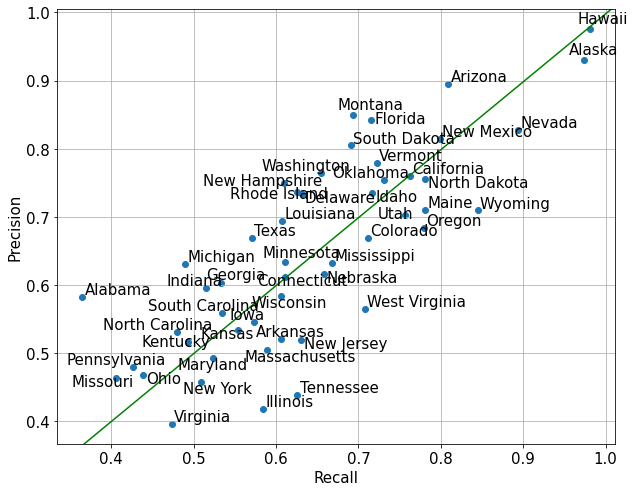

In [38]:
fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(recall, precision)

for txt, p, r in zip(VOCAB, precision, recall):
    txt = rename.get(txt, txt)
    x, y = r, p
    shifts = {
        "Hawaii": (-6, 1),
        "Alaska": (-7, 1),
        "Montana": (-7, 1),
        "Florida": (0.5, -2),
        "North Dakota": (0,-4),
        "Idaho": (0.5,-4),
        "Utah": (-12,-2),
        "Washington": (-25, 0),
        "New Hampshire": (-34, -2),
        "Rhode Island": (-28, -3),
        "Oklahoma": (-22,0),
        "Missouri": (-19,-4),
        "Ohio": (0, -4),
        "Massachusetts": (-10, -5),
        "North Carolina": (-31,0),
        "Kentucky": (-20, -2.5),
        "Pennsylvania": (-28, 0),
        "New York": (-8, -5),
        "Maryland": (-15, -5),
        "Kansas": (-16,-4),
        "South Carolina": (-31,0),
        "Indiana": (-17,0),
        "Iowa": (-11,0),
        "Arkansas": (-11,0),
        "New Jersey": (0,-4),
        "Wisconsin": (-13,-5),
        "Connecticut": (-12,-4),
        "Georgia": (-7,0.5),
        "Nebraska": (0,-4),
        "Minnesota": (-10,0.5),
        "Delaware": (0,-4),
    }
    x += (shifts.get(txt, (0,0))[0] + 1) * 0.003
    y += (shifts.get(txt, (0,0))[1] + 1) * 0.004
    ax.annotate(txt, (x, y))
    
line = matplotlib.lines.Line2D([0.049,0.994],[0.,1.],color='green')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
    
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()

In [50]:
pr_data.tail()

y  y_hat  correct  y_state y_hat_state
100008  49     43    False  Wyoming        Utah
100009  49      5    False  Wyoming    Colorado
100010  49     43    False  Wyoming        Utah
100011  49     30    False  Wyoming  New Mexico
100012  49      5    False  Wyoming    Colorado

In [91]:
sns.set(font_scale=2.2)

In [92]:
def analyze_acc(states, recall: bool):
    ytrue = pr_data.y_state
    ypred = pr_data.y_hat_state
    if not recall:  # Precision
        ytrue, ypred = ypred, ytrue

    cm = confusion_matrix(y_true=ytrue, y_pred=ypred)
    df_cm = pd.DataFrame(cm, index=VOCAB, columns=VOCAB)
    df_cm = df_cm.divide(df_cm.sum(1), 0)
    df_cm = df_cm.loc[states]

    # Make a nice ordering
    state_to_row = df_cm.idxmax(0).sort_values()
    starts = [states] + [state_to_row[state_to_row==s].index.tolist() for s in states]
    order = VOCAB
    for start in reversed(starts):
        order = start + [s for s in order if s not in start]
    df_cm = df_cm[order]

    # Remove cols that don't have anything
    df_cm = df_cm.loc[:,df_cm.max(0) > 0.02]

    plt.figure(figsize=(17, 3.2))
    sns.heatmap(df_cm, annot=False, cbar=False, cmap=matplotlib.cm.bone_r)
    plt.show()
    plt.pause(0.001)

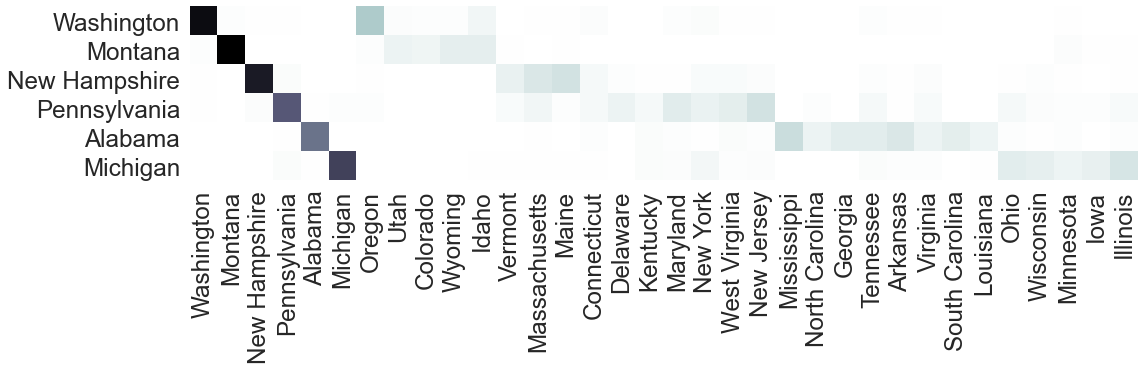

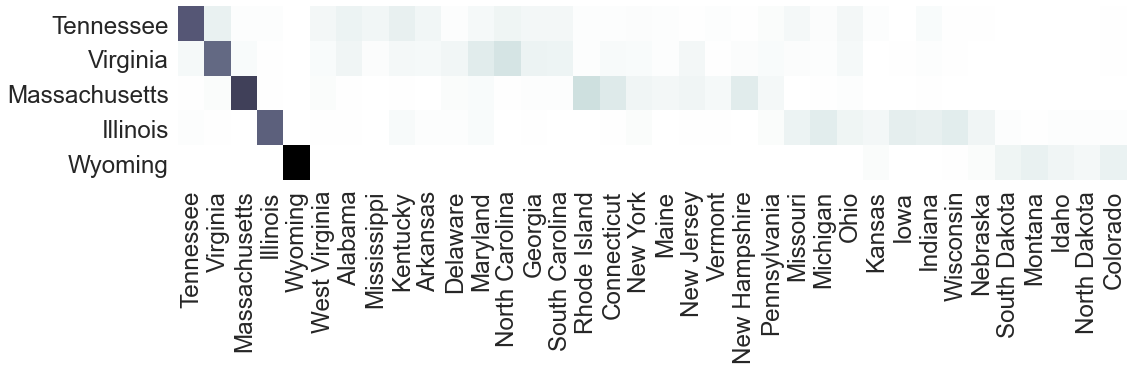

In [93]:
# RECALL
analyze_acc(["Washington", "Montana", "New Hampshire", "Pennsylvania", "Alabama", "Michigan"], recall=True)

# PRECISION
analyze_acc(["Tennessee", "Virginia", "Massachusetts", "Illinois", "Wyoming"], recall=False)

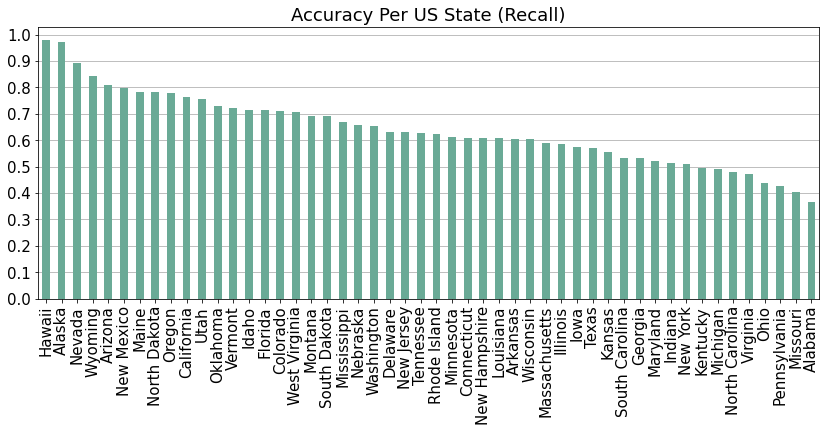

In [39]:
fig, ax = plt.subplots(figsize=(14,5))
recall.sort_values(ascending=False).plot.bar(ax=ax, color="#6aaa96", zorder=3)
plt.xlabel("")
plt.yticks(np.arange(0,1.01,0.1))
ax.grid(axis='y', zorder=0)
plt.title("Accuracy Per US State (Recall)")
plt.show()

In [92]:
### GEOCELL ACCURACIES ###

In [93]:
data_gc = deepcopy(data)
data_gc['geocell_pred'] = pkl_load('logits_geocell').argmax(1)
data_gc['geocell_correct'] = data_gc.geocell_idx == data_gc.geocell_pred
data_gc = data_gc[data_gc.set.isin(['valid','test'])]

In [94]:
geocell_acc = data_gc.groupby('geocell_idx').geocell_correct.mean().reset_index()
geocell_acc = geocell_acc.rename(columns={'geocell_correct': 'recall'})

In [95]:
geocell_count_all = data.groupby('geocell_idx').id.count().reset_index().rename(columns={'id': 'count'})
geocell_count_vlts = data_gc.groupby('geocell_idx').id.count().reset_index().rename(columns={'id': 'count_vlts'})
geocell_count = geocell_count_all.merge(geocell_count_vlts, on='geocell_idx')

In [96]:
data_gc = data_gc.merge(geocell_acc, on='geocell_idx').merge(geocell_count, on='geocell_idx')

In [107]:
def inspect_loc(lat, lng, zoom):
    fig = px.scatter_mapbox(
        data_gc.rename(columns={'recall': 'Recall'}),
        lat="lat",
        lon="lng",
        color="Recall",
        hover_data=["geocell_idx", "count", "count_vlts"],
        color_continuous_scale=px.colors.sequential.Plasma_r,
    )
    fig.update_layout(
        mapbox_style="open-street-map",
        margin=dict(t=0, b=0, l=0, r=0),
        mapbox=dict(
            center={'lat': lat, 'lon': lng},
            zoom=zoom,
        ),
    )
    fig.show()

In [108]:
# Zoom out a bit more to get the whole world
inspect_loc(0,0,1)

In [109]:
# Paris
inspect_loc(48.9,2.35,6)

In [110]:
def gc_misses(gc_idx, lat, lng, zoom):
    dgc = data_gc[data_gc.geocell_idx==gc_idx]
    dgc = dgc.groupby('geocell_pred').id.count().reset_index().rename(columns={'id': 'miss_count'})
    dgc = dgc[dgc.miss_count > 1]
    dgc['fraction'] = dgc.miss_count / dgc.miss_count.sum()
    if gc_idx not in dgc.geocell_pred:
        dgc = dgc.append({'geocell_pred': gc_idx, 'fraction': 0}, ignore_index=True)
    attrs = pd.merge(data, dgc, left_on='geocell_idx', right_on='geocell_pred')
    attrs = attrs.merge(geocell_count, on='geocell_idx')
    attrs.head()
 
    fig = px.scatter_mapbox(
        attrs,
        lat="lat",
        lon="lng",
        color="fraction",
        hover_data=["geocell_idx", "count", "count_vlts"],
        color_continuous_scale=px.colors.sequential.Plasma_r,
    )
    fig.update_layout(
        mapbox_style="open-street-map",
        margin=dict(t=0,b=0,l=0,r=0),
        mapbox=dict(
            center={'lat': lat, 'lon': lng},
            zoom=zoom,
        ),
    )
    fig.show()
    plt.pause(0.001)

In [111]:
# Nice! The only two misses were above (SF) and below (LA)
# - Still surpsising that it predicted absolutely *zero* correct out of 28
gc_misses(159, 36, -121, 5)

In [102]:
# Paris
gc_misses(269, 48.9, 2.35, 3)

In [112]:
# Shows that a more smart geocell design would have helped
gc_misses(86, 51.87, -10.83, 2.5)

In [142]:
### EFFECT OF POP DENSITY ON COUNTRY PRED ACC #

In [144]:
data_pop = deepcopy(data)
data_pop['country_pred'] = pkl_load('logits_country').argmax(1)
data_pop['geocell_pred'] = pkl_load('logits_geocell').argmax(1)
data_pop['country_correct'] = data_pop.country_idx == data_pop.country_pred
data_pop['geocell_correct'] = data_pop.geocell_idx == data_pop.geocell_pred
data_pop = data_pop[data_pop.set.isin(['valid','test'])]

In [170]:
data_pop["pop_bin"] = pd.cut(data_pop.population, 15, precision=2)

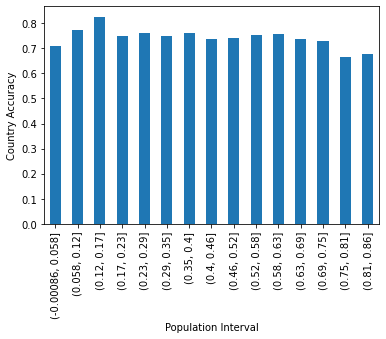

In [171]:
data_pop.groupby('pop_bin').country_correct.mean().plot(kind="bar")
plt.xlabel("Population Interval")
plt.ylabel("Country Accuracy")
plt.show()

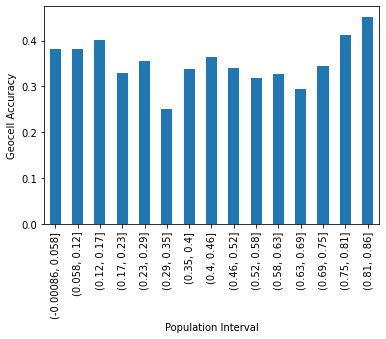

In [172]:
data_pop.groupby('pop_bin').geocell_correct.mean().plot(kind="bar")
plt.xlabel("Population Interval")
plt.ylabel("Geocell Accuracy")
plt.show()